In [33]:
import sys
sys.path.append("../../src")
import numpy as np
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

plt.style.use(["science","bright"])

In [34]:
N_p                 = 9
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0], [int((N_p-1)/2),0,0], [N_p-1,0,0], 
                            [0,int((N_p-1)/2),0], [0,N_p-1,0], [N_p-1,int((N_p)/2),0],
                            [int((N_p)/2),(N_p-1),0], [N_p-1,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant',
                           'constant','constant','constant','floating']
}
target_electrode    = len(topology_parameter["e_pos"])-1

In [35]:
# N_p                 = 81
# topology_parameter  = {
#     "Np"                : N_p,
#     "Nj"                : 0,
#     "Nz"                : 1,
#     "e_pos"             : [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]],
#     "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
# }
# target_electrode    = len(topology_parameter["e_pos"])-1

In [36]:
values_AND_9    = [0.085337,0.00,-0.03929,0.00,-0.022938,0.010342,0.002624,0.0,0.0]
values_AND_11   = [0.017308,0.00,0.070893,0.00,0.073702,0.038,0.030185,0.0,0.0]
values_AND_13   = [0.089993,0.00,0.063558,0.00,-0.048817,0.011171,0.037835,0.0,0.0]

values_XOR_9    = [-0.094029,0.00,0.051392,0.00,0.03737,-0.040439,-0.043346,0.0,0.0]
values_XOR_11   = [-0.044536,0.00,0.066428,0.00,0.096061,-0.021845,-0.081427,0.0,0.0]
values_XOR_13   = [-0.070379,0.00,0.091417,0.00,0.08231,-0.015387,-0.013483,0.0,0.0]

# voltages        = np.tile(np.round(values_AND_13,3), (4,1))
voltages        = np.tile(values_XOR_9, (4,1))
voltages[:,1]   = [0.0,0.0,0.01,0.01]
voltages[:,3]   = [0.0,0.01,0.0,0.01]
voltages

array([[-0.094029,  0.      ,  0.051392,  0.      ,  0.03737 , -0.040439,
        -0.043346,  0.      ,  0.      ],
       [-0.094029,  0.      ,  0.051392,  0.01    ,  0.03737 , -0.040439,
        -0.043346,  0.      ,  0.      ],
       [-0.094029,  0.01    ,  0.051392,  0.      ,  0.03737 , -0.040439,
        -0.043346,  0.      ,  0.      ],
       [-0.094029,  0.01    ,  0.051392,  0.01    ,  0.03737 , -0.040439,
        -0.043346,  0.      ,  0.      ]])

In [37]:
list_results    = []
for i in range(5):
    sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode)
    results     = sim_class.return_output_values()
    states      = sim_class.return_potential_landscape()*1000
    list_results.append(results)

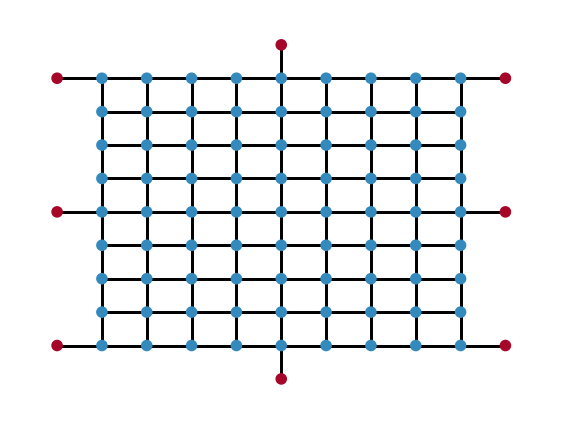

In [38]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
fig, ax = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=10)

Text(0, 0.5, '$U$ [mV]')

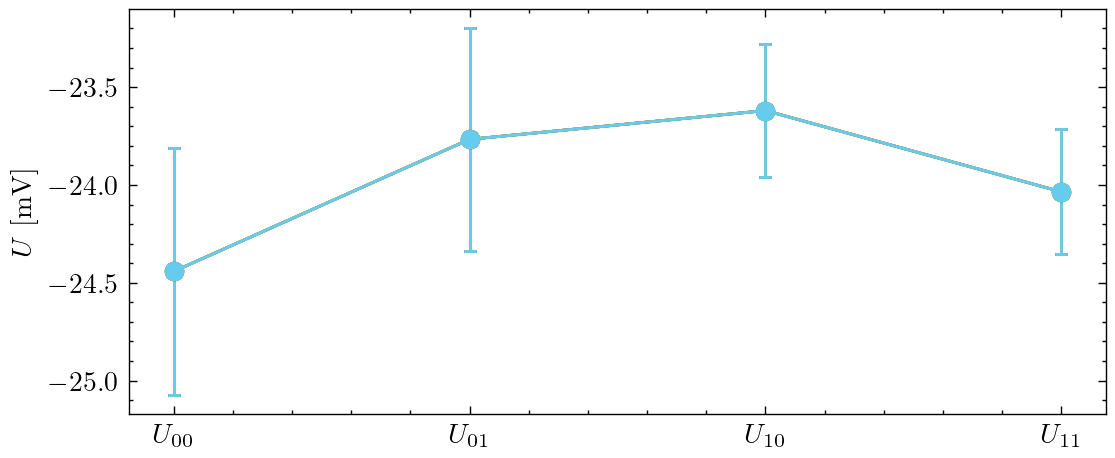

In [39]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot()
for results in list_results:
    ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"],
                results[:,2]*1000, results[:,3]*1000, marker='o', capsize=2)
ax.set_ylabel("$U$ [mV]")

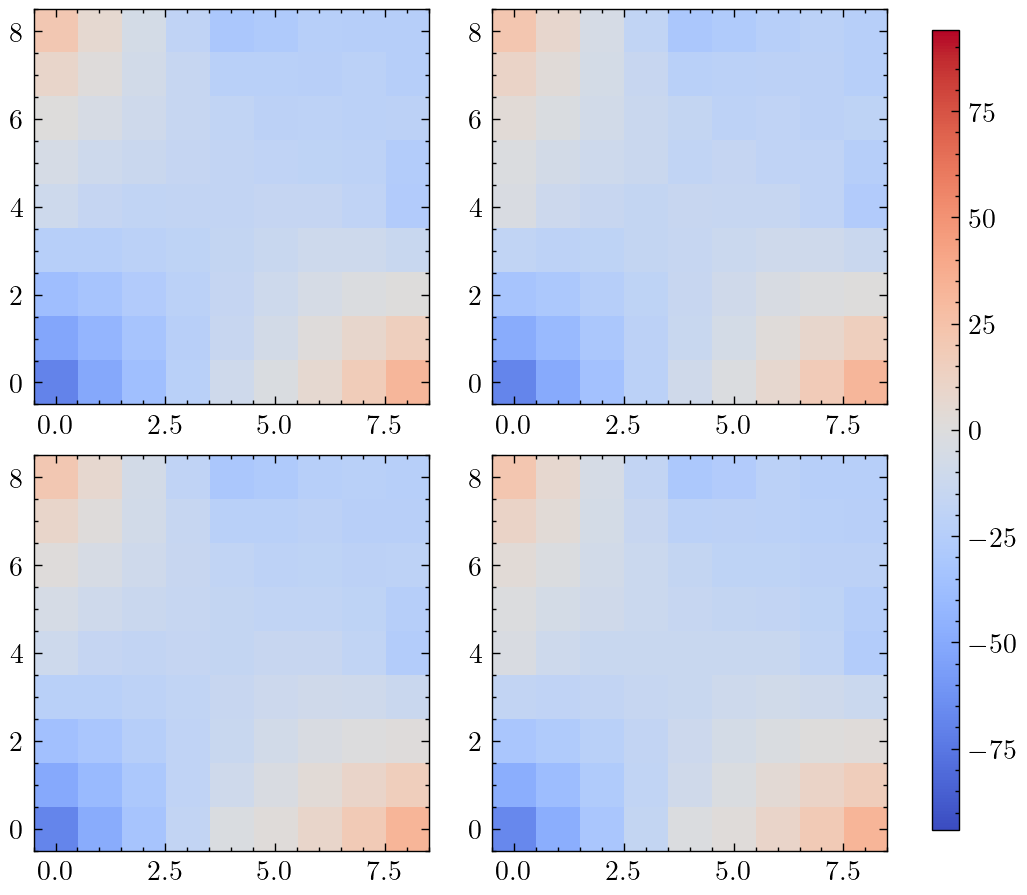

In [40]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.7)
fig.set_figwidth(fig.get_figwidth()*1.5)

vmin = -np.max(np.abs(states))
vmax = np.max(np.abs(states))

# Create subplots and add imshow plots
axes = []
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    im = ax.imshow(states[i, 8:].reshape(N_p, -1), cmap='coolwarm', interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    axes.append(ax)

# Add a figure-level colorbar
fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.95, label="", aspect=30)